In [12]:
import pm4py
import pandas as pd

In [13]:
log = pm4py.read_xes("log.xes")

parsing log, completed traces :: 100%|██████████| 100000/100000 [00:23<00:00, 4328.91it/s]


#### Lista as 10 principais variantes do log de eventos

In [14]:
from pm4py.statistics.variants.log import get as variants_get
variants = variants_get.get_variants(log)

from collections import Counter
c = Counter({k: len(v) for k,v in variants.items()})
for v,f in c.most_common(10):
    print(f, ":", v)

33673 : ('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
22373 : ('NEW',)
20902 : ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
4813 : ('NEW', 'DELETE')
3508 : ('NEW', 'FIN')
2121 : ('NEW', 'CHANGE DIAGN', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
1555 : ('NEW', 'CHANGE DIAGN', 'DELETE')
977 : ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'BILLED')
869 : ('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'REOPEN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED')
512 : ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CODE OK')


#### Conversão de log para DataFrame

In [15]:
from pm4py.objects.conversion.log import converter as log_converter

df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

df = df.rename(columns={
    "case:concept:name": "case",
    "concept:name": "activity",
    "time:timestamp": "timestamp"
})
df["activity"] = df["activity"].str.upper().str.strip().str.replace(" ", "_")
df.head()


,isCancelled,diagnosis,timestamp,caseType,speciality,org:resource,activity,blocked,isClosed,flagD,...,lifecycle:transition,case,closeCode,actRed,actOrange,flagC,msgCount,version,msgType,msgCode
0,False,A,2012-12-16 19:33:10+00:00,A,A,ResA,NEW,False,True,True,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2013-12-15 19:00:37+00:00,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,complete,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2013-12-16 03:53:38+00:00,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2013-12-17 12:56:29+00:00,NaN,NaN,NaN,CODE_OK,NaN,NaN,NaN,...,complete,A,NaN,False,False,False,0.0,A,NaN,NaN
4,NaN,NaN,2013-12-19 03:44:31+00:00,NaN,NaN,ResB,BILLED,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Ordena dataframe por timestamp 

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(["case", "timestamp"])


#### Elimina traços que tenham tamanho menor que 1 
Foi utilizado pois 22373 casos simplesmente são iniciados e em seguida finalizados, causando ruido: ('NEW',)

In [ ]:
df = df[df["activity"] != "EMPTY"]
trace_sizes = df.groupby("case").size()
valid_cases = trace_sizes[trace_sizes > 1].index
df = df[df["case"].isin(valid_cases)]


#### Remove os traços 1% mais raros

In [ ]:
activity_counts = df["activity"].value_counts()

threshold = activity_counts.quantile(0.01)  

common_activities = activity_counts[activity_counts >= threshold].index
df = df[df["activity"].isin(common_activities)]
print(activity_counts)

activity
NEW             78916
FIN             74738
RELEASE         70926
CODE_OK         68006
BILLED          67448
CHANGE_DIAGN    45451
DELETE           8225
REOPEN           4669
CODE_NOK         3620
STORNO           2973
REJECT           2016
SET_STATUS        705
MANUAL            372
JOIN-PAT          358
CODE_ERROR         75
CHANGE_END         38
ZDBC_BEHAN          1
Name: count, dtype: int64


#### Converte novamente para event log 

In [ ]:
case_activities = df.groupby("case")["activity"].unique()

valid_cases = case_activities[case_activities.apply(lambda acts: any(a != "NEW" for a in acts))].index

df = df[df["case"].isin(valid_cases)]

In [ ]:
log_clean = pm4py.format_dataframe(
    df,
    case_id='case',
    activity_key='activity',
    timestamp_key='timestamp'
)

log_clean = pm4py.convert_to_event_log(log_clean)

#### Cria rede de petri com o log limpo

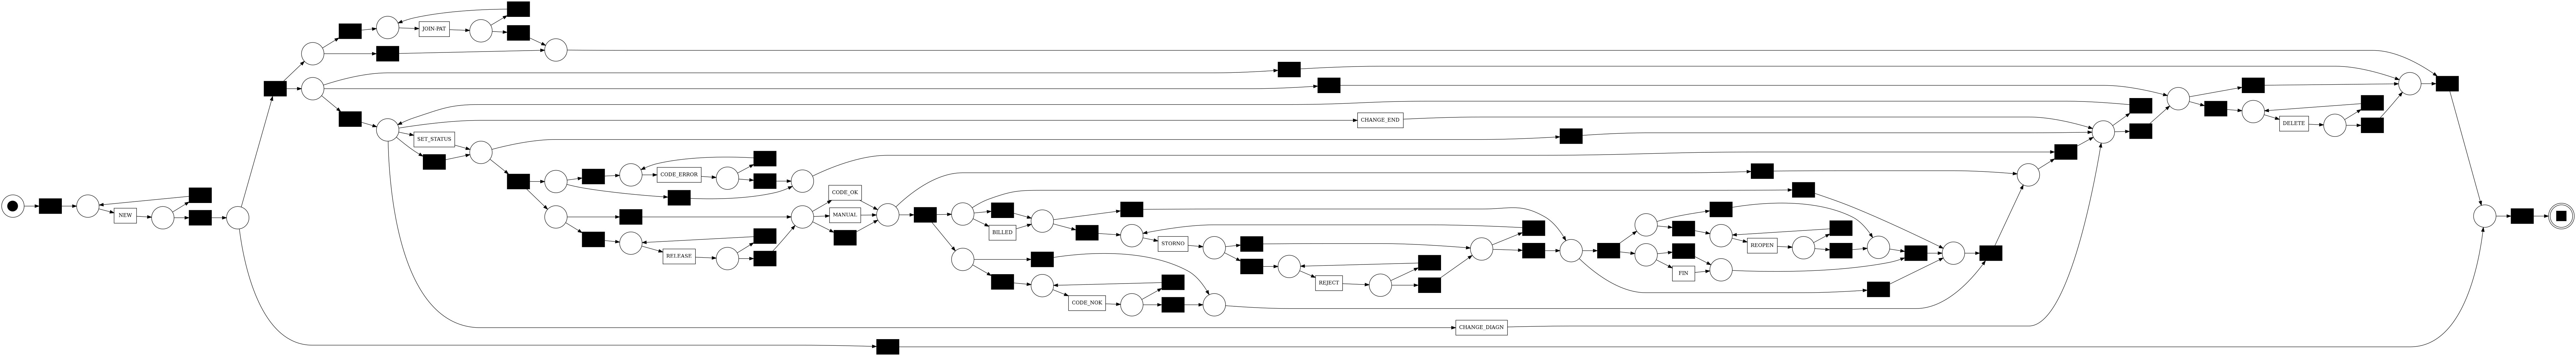

In [25]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

tree = inductive_miner.apply(log_clean)
net, im, fm = pt_converter.apply(tree)
pm4py.view_petri_net(net, im, fm)



#### Exporta novamente para XES

In [26]:
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

xes_exporter.apply(log_clean, "log_clean.xes")

exporting log, completed traces :: 100%|██████████| 77627/77627 [00:56<00:00, 1377.29it/s]
